# HW6: Machine learning

**Due Wednesday April 6, 8pm**

(AY250 2022)

### Casey Lam, casey_lam@berkeley.edu

### Collaborators: #hw6-discussion channel

## Galaxy Classification with CNNs

Galaxies appear with different shapes and colors depending on a number of factors, including age, distance, and history of mergers with other galaxies. A crowd-sourced group was [asked to visually classify a set of galaxies from a telescope survey](https://data.galaxyzoo.org/gz_trees/gz_trees.html), resulting in a labelled dataset of 21,785 galaxies across 10 different labels.

You can download it locally:
```bash
curl -o galaxies10.h5 http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5
```
Or access it on the shared drive on `astro.datahub.berkeley.edu` at `shared/HW_6/galaxies10.h5`

First, load the data:

In [11]:
import h5py
import numpy as np
from tensorflow.keras import utils

# To get the images and labels from file
with h5py.File('../../shared/HW_6/galaxies10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])

# Convert the labels to categorical 10 classes
labels = utils.to_categorical(labels, 10)

# Convert to desirable type
labels = labels.astype(np.float32)
images = images.astype(np.float32)

print(f"labels shape: {labels.shape}")
print(f"images shape: {images.shape}")

labels shape: (21785, 10)
images shape: (21785, 69, 69, 3)


### Visualize and inspect

In a single, multi-panel figure visualize one randomly chosen galaxy from each of the 10 classes. Be sure to set the random seed so that your figure will be reproducible. 

In [12]:
idx_arr = np.empty(10)

for ii in np.arange(10):
    np.random.seed(0)
    idx_arr[ii] = np.random.choice(np.where(labels[:,ii] == 1)[0])

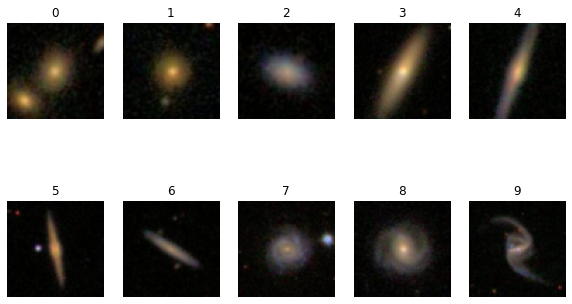

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10,6))
for ii, ax in enumerate(axes.flatten()):
    ax.imshow(images[int(idx_arr[ii])].astype(np.uint8))
    ax.axis("off")
    ax.set_title(ii)

Show a histogram of the distribution of galaxies across classes. Comment on any differences you notice with this dataset and the MNIST.

<BarContainer object of 10 artists>

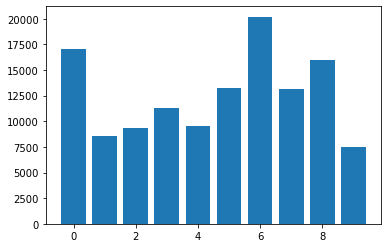

In [14]:
plt.bar(np.arange(10), idx_arr)

They're both imaging data, but for MNIST there is definitely a "right" answer, while for galaxies there isn't. 

### Prepare for training

First, split the dataset into a train, validation, and test set with a fixed random seed. Then, construct a simple (~few layers) CNN that will accommodate the 69x69x3 images and return a classification. Hint: you will need to modify the networks we built in class to handle the 3d inputs (check out `Conv3D` https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv3D).

In [15]:
# Split up into train, validation, and test set.
nim = int(labels.sum())
idx = np.arange(nim) 

split1 = int(0.9 * len(idx))
split2 = int(0.95 * len(idx))

np.random.seed(0)
np.random.shuffle(idx)

# Images
X_train = images[idx[:split1]]
X_valid = images[idx[split1:split2]]
X_test = images[idx[split2:]]

# Labels 
la_train = labels[idx[:split1]]
la_valid = labels[idx[split1:split2]]
la_test = labels[idx[split2:]]

In [16]:
from tensorflow.keras.utils import to_categorical

nb_classes = 10
batch_size = 128

# convert class vectors to binary class matrices
Y_train = to_categorical(la_train, nb_classes)
Y_valid = to_categorical(la_valid, nb_classes)
Y_test = to_categorical(la_test, nb_classes)

input_shape = (69,) + X_train[0].shape 
input_shape

(69, 69, 69, 3)

### Train

Using early stopping and learning rate decay, train the network you built. Use the validation dataset at the end of each epoch for the early stopping. You might decide to do this part on colab for GPU access.

### Evaluation

Use your trained model and apply it to the test set. How well did you do (total accuracy)? Plot a confusion matrix and comment where the network was most confused.

### Improve - data augmentation

Now that you have a baseline accuracy, you can work to try to improve the results. Without changing your network architecture, implement a data augmentation strategy, retrain, and then reevaluate. How much improvement did you see?

### Improve - network

Change/embellish your original network to try to improve the results (try adding layers, changing the initialization of the kernel weights, changing the activation, adding dropout). You can use an automl trainer if you'd like or try different approaches by hand. Retrain and then reevaluate. Explain what you did but only show us the best model and its evaluation.

## Autoencoders

A form of non-parametric representation learning with neutral nets, where the architecture of the network is used to reduce the dimensionality of the data. First, go through (and execute) the following codeblocks and make sure you understand what they are doing to build and use an autoencoder.

As the name suggests, autoencoders uses the data itself to learn the best way to represent it in a compact way--it's a form of semantic compression. This is a family of self- (or un-) supervised modeling.

<img src="https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png">
Source: https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html

In practice, we take an input X (which may be a 1-d vector, 2-d image, ...) and try to squeeze it down to a smaller number of values in the "bottleneck" layer and then uncompress back to it's original shape and form. The loss function that we construct will be the way in which the network learns on each backprop through the data.

Let's look at a autoencoder which uses convnets to restruct the fashion dataset.

In [ ]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow 
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, \
                                    Activation, BatchNormalization, UpSampling2D
from tensorflow.keras import backend as K
import tensorflow as tf

# Print keras version
print(tensorflow.keras.__version__)

from tensorflow.keras.utils import to_categorical

fashion_mnist = tf.keras.datasets.fashion_mnist

nb_classes = 10
batch_size = 128
bottleneck_size = 64

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # scale the images to 0-1

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# convert class vectors to binary class matrices
Y_train =  to_categorical(y_train, nb_classes)
Y_test =  to_categorical(y_test, nb_classes)

input_shape = x_train[0].shape  + (1,)
input_shape
input_img = Input(shape = (28, 28, 1))

Make a simple autoencoder

In [ ]:
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Flatten()(x)
bottleneck = Dense(bottleneck_size, name="bottleneck")(x)

x = Dense(128)(bottleneck)
x = Reshape((4, 4, 8))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# add with tf.device('/gpu:0'): if on GPU
autoencoder = Model(input_img, decoded)


logdir = os.path.join(
    "nn_results", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
run_time_string = datetime.datetime.utcnow().isoformat(timespec='minutes')

model_path = f'nn_results/ay250_autoencoder_nn_{run_time_string}.h5'
print(f"Training ... {model_path}")


model_check = tf.keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=1)

tensorboard_callback = \
    tensorflow.keras.callbacks.TensorBoard(logdir,
                                           histogram_freq=0,
                                           write_graph=True,
                                           write_grads=False,
                                           write_images=False,
                                           embeddings_freq=0,
                                           embeddings_layer_names=None,
                                           embeddings_metadata=None, embeddings_data=None)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_train = autoencoder.fit(x_train, x_train,
                                    batch_size=batch_size, epochs=10,
                                    verbose=1, shuffle=False,
                                    validation_data=(x_test, x_test),
                                    callbacks=[tensorboard_callback, model_check])

In [ ]:
from tensorflow.keras.models import load_model
latest_model_file = !ls -t1 nn_results/ay250_*.h5 | head -1
latest_model_file = latest_model_file[0]
print(f"Using {latest_model_file}")
autoencoder = load_model(latest_model_file)

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Classify using Random Forest

Using the autoencoder model above, create a random forest model to predict the classes of the images using the 64-parameter bottleneck layer. What accuracy do you get? How does it compare with the accuracy we got on the `convnet` model before?

### Bottleneck size variation

Experiment with trying a different sized layer (e.g., size 4, 16, 32) and repeat step a) above. Do you see any trends with bottleneck size?